Make a big pandas dataframe to hold all the metric values we're interested in, so then we can pass it around and plot it up any way we like

I guess depth in each filter for each DDF?



In [1]:
import glob
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pylab as plt
import os
%matplotlib inline

In [2]:
# I just coppied them over from hyak and sym linked them to this directory for ease of use
glance_dirs = glob.glob('./*_glance')
sci_dirs = glob.glob('./*_sci')

glance_dirs.sort()
sci_dirs.sort()


In [3]:
sci_dirs


['./weight_scan_fpw0.1_v2.0_10yrs_sci',
 './weight_scan_fpw0.3_v2.0_10yrs_sci',
 './weight_scan_fpw0.6_v2.0_10yrs_sci',
 './weight_scan_fpw1.0_v2.0_10yrs_sci',
 './weight_scan_fpw1.5_v2.0_10yrs_sci',
 './weight_scan_fpw10.0_v2.0_10yrs_sci',
 './weight_scan_fpw20.0_v2.0_10yrs_sci',
 './weight_scan_fpw3.0_v2.0_10yrs_sci',
 './weight_scan_fpw6.0_v2.0_10yrs_sci']

In [4]:
glance_dirs

['./weight_scan_fpw0.1_v2.0_10yrs_glance',
 './weight_scan_fpw0.3_v2.0_10yrs_glance',
 './weight_scan_fpw0.6_v2.0_10yrs_glance',
 './weight_scan_fpw1.0_v2.0_10yrs_glance',
 './weight_scan_fpw1.5_v2.0_10yrs_glance',
 './weight_scan_fpw10.0_v2.0_10yrs_glance',
 './weight_scan_fpw20.0_v2.0_10yrs_glance',
 './weight_scan_fpw3.0_v2.0_10yrs_glance',
 './weight_scan_fpw6.0_v2.0_10yrs_glance']

In [5]:
filenames = [name.replace('./', '').replace('_glance', '') for name in glance_dirs]

In [6]:
runNames =  [name[2:].replace('_v2.0_10yrs_glance','').replace('v2.0_10yrs_glance','').replace('v2.0_10yrs_glance','') for name in glance_dirs] 
versions = ['1.7']*len(glance_dirs) 

In [7]:
runNames

['weight_scan_fpw0.1',
 'weight_scan_fpw0.3',
 'weight_scan_fpw0.6',
 'weight_scan_fpw1.0',
 'weight_scan_fpw1.5',
 'weight_scan_fpw10.0',
 'weight_scan_fpw20.0',
 'weight_scan_fpw3.0',
 'weight_scan_fpw6.0']

In [8]:
# Set up the dataframe
df = pd.DataFrame(np.array([runNames, versions]).T, columns=['runName', 'version'])

In [9]:
# List of tupes with (metricName, summaryName) that we want to pull from glance dirs
mnamesname =[('parallax', 'best18k'),
            ('properMotion', 'best18k'),
            ('fO', 'fONv MedianNvis'),
            ('fO', 'fOArea')]

In [10]:
for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s") and summaryName= "%s";' % (names[0], names[1])
    for directory in glance_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

In [11]:
# Add the median coadded depths in each filter
for filtername in 'ugrizy':
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "CoaddM5" and metricMetadata=" %s") and summaryName= "Median";' % (filtername)
    for directory in glance_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df['median_coadd_%s' % filtername] = column_vals


In [24]:
# List of tupes with (metricName, summaryName) that we want to pull from science dirs
mnamesname =[('SNNSNMetric_nSN', 'Sum'),
            ('Fast Microlensing', 'Mean'),
            ('Slow Microlensing', 'Mean'),
            ('KNePopMetric__multi_color_detect', 'Fraction detected of total'),
            ('GalaxyCountsMetric_extended', 'N Galaxies (all)'),
            ('TDEsPopMetric__some_color', 'Mean'),
             ('TDEsPopMetric__some_color_pu', 'Mean'), 
            ('WeakLensingNvisits', 'Median')]

In [25]:
for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

In [26]:
sql

'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "WeakLensingNvisits") and summaryName= "Median";'

In [27]:
# things that need some metadata
mnamesname =[('Nstars_no_crowding', 'Total N Stars, no crowding')]

for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s" and metricMetadata=" i") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

    
mnamesname =[('ExgalM5_with_cuts', '3x2ptFoM')]

for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s" and metricMetadata="i band non-DD year 10") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            try:
                column_vals.append(np.max(result))
            except:
                import pdb ;pdb.set_trace()
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals


In [28]:
np.max(result)

33.555541087248834

In [31]:
# Pull the DDF depths from everywhere. 
filters = 'ugrizy'
ddf_names = ['DD:ELAISS1', 'DD:XMM-LSS', 'DD:ECDFS', 'DD:COSMOS', 'DD:EDFSa', 'DD:EDFSb']

for filtername in filters:
    for ddf_name in ddf_names:
        column_vals = []
        sql = 'select summaryValue from summarystats where summaryName="Median depth %s, %s"' % (ddf_name, filtername)
        for directory in sci_dirs:
            conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
            result = pd.read_sql(sql, conn).values.ravel()
            if np.size(result) > 1:
                ValueError
            else:
                column_vals.append(np.max(result))
            conn.close()
        df[ddf_name+','+filtername] = column_vals

In [32]:
sql

'select summaryValue from summarystats where summaryName="Median depth DD:EDFSb, y"'

In [35]:
# Now to pull things from the solar system results

# here's what we used last time:
#'3 pairs in 15 nights detection loss NEO H=16.0',
#        '3 pairs in 30 nights detection loss NEO H=22.0',
#       '3 pairs in 15 nights detection loss TNO H=4.0'

faint_neo = []
bright_neo = []
tno = []

for name in filenames:
    conn = sqlite3.connect('%s_ss/resultsDb_sqlite.db' % name)
    sql = 'select summaryValue from summarystats where summaryName="DifferentialCompleteness H = 16.000000" and '+\
        'metricId = (select metricId from metrics where metricName ="Discovery_N_Chances" and metricMetadata="NEO 3 pairs in 15 nights detection loss")'
    val = np.max(pd.read_sql(sql, conn).values.ravel())
    bright_neo.append(val)
    
    
    sql = 'select summaryValue from summarystats where summaryName="DifferentialCompleteness H = 22.000000" and '+\
        'metricId = (select metricId from metrics where metricName ="Discovery_N_Chances" and metricMetadata="NEO 3 pairs in 15 nights detection loss")'

    val = np.max(pd.read_sql(sql, conn).values.ravel())
    faint_neo.append(val)
    
    #conn.close()
    #conn = sqlite3.connect('%s_l7_5k/resultsDb_sqlite.db' % name)
    
    sql = 'select summaryValue from summarystats where summaryName="DifferentialCompleteness H = 6.000000" and '+\
          'metricId = (select metricId from metrics where metricName ="Discovery_N_Chances" and metricMetadata="TNO 3 pairs in 15 nights detection loss")'

    val = np.max(pd.read_sql(sql, conn).values.ravel())
    tno.append(val)
    conn.close()
    
df['NEO bright'] = bright_neo
df['NEO faint'] = faint_neo 
df['TNO'] = tno

In [36]:
df['NEO faint']

0    0.4068
1    0.3962
2    0.3988
3    0.3924
4    0.3884
5    0.3398
6    0.3300
7    0.3688
8    0.3538
Name: NEO faint, dtype: float64

In [37]:
df['NEO bright']

0    0.9280
1    0.9266
2    0.9284
3    0.9314
4    0.9354
5    0.9468
6    0.9484
7    0.9396
8    0.9446
Name: NEO bright, dtype: float64

In [38]:
runNames[0]

'weight_scan_fpw0.1'

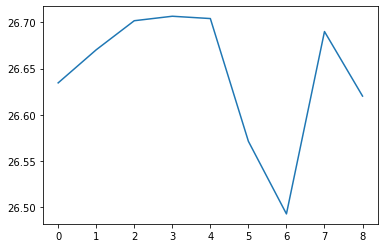

In [39]:
plt.plot(df['median_coadd_g'])

In [40]:
df.columns

Index(['runName', 'version', 'parallax_best18k', 'properMotion_best18k',
       'fO_fONv MedianNvis', 'fO_fOArea', 'median_coadd_u', 'median_coadd_g',
       'median_coadd_r', 'median_coadd_i', 'median_coadd_z', 'median_coadd_y',
       'SNNSNMetric_nSN_Sum', 'Fast Microlensing_Mean',
       'Slow Microlensing_Mean',
       'KNePopMetric__multi_color_detect_Fraction detected of total',
       'GalaxyCountsMetric_extended_N Galaxies (all)',
       'TDEsPopMetric__some_color_Mean', 'TDEsPopMetric__some_color_pu_Mean',
       'WeakLensingNvisits_Median',
       'Nstars_no_crowding_Total N Stars, no crowding',
       'ExgalM5_with_cuts_3x2ptFoM', 'DD:ELAISS1,u', 'DD:XMM-LSS,u',
       'DD:ECDFS,u', 'DD:COSMOS,u', 'DD:EDFSa,u', 'DD:EDFSb,u', 'DD:ELAISS1,g',
       'DD:XMM-LSS,g', 'DD:ECDFS,g', 'DD:COSMOS,g', 'DD:EDFSa,g', 'DD:EDFSb,g',
       'DD:ELAISS1,r', 'DD:XMM-LSS,r', 'DD:ECDFS,r', 'DD:COSMOS,r',
       'DD:EDFSa,r', 'DD:EDFSb,r', 'DD:ELAISS1,i', 'DD:XMM-LSS,i',
       'DD:ECDFS,i', '

In [41]:
# pickle would be much smaller, but I guess can zip after if we want to
df.to_hdf('combined_maf_dataframe.hdf', 'maf')
# restore with:
# df = pd.read_hdf('combined_maf_dataframe.hdf', 'maf')